In [2]:
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

import mplhep
import zfit

mplhep.set_style('CMS')
zfit.__version__

'0.5.6'

### load image

In [3]:
im = Image.open('images/-0.5065000057220459__CYGNO_60_40_He_NR_20_keV_930V_30cm_SRIM_IDAO_iso_crop_hist_pic_run3_ev269.png')

In [4]:
ima = np.array(im)

In [5]:
step = 50
left, right = round(ima.shape[0]/2 - step), round(ima.shape[0]/2 + step)
ima_x = np.sum(ima[left:right, left:right], axis=0)

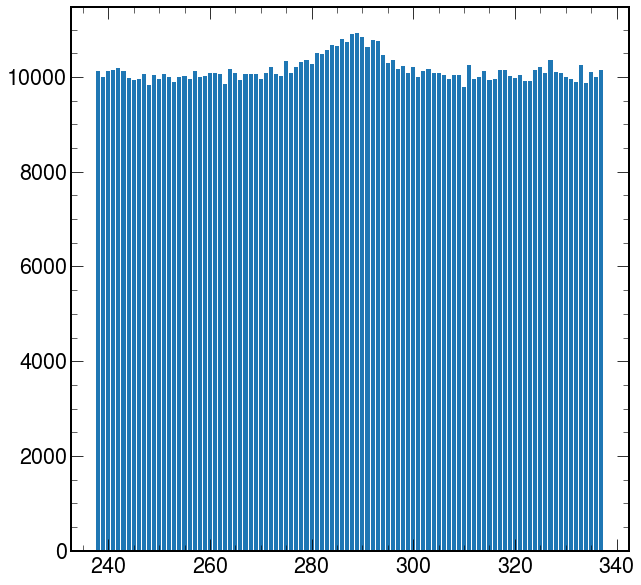

In [6]:
plt.bar(range(left, right), ima_x)
plt.show()

### model

In [9]:
# create space
obs = zfit.Space("x", limits=(left, right))

# parameters
mu = zfit.Parameter("mu", (left-right)/2, left, right)
sigma = zfit.Parameter("sigma", 10., 0.1, 50)
lambd = zfit.Parameter("lambda", -0.01, -1, -0.000001)

# model building, pdf creation
gauss = zfit.pdf.Gauss(mu=mu, sigma=sigma, obs=obs)
# exponential = zfit.pdf.Exponential(lambd, obs=obs)
uniform = zfit.pdf.Uniform(left, right, obs) 

n_bkg = zfit.Parameter('n_bkg', sum(ima_x))
n_sig = zfit.Parameter('n_sig', 1000)
gauss_extended = gauss.create_extended(n_sig)
# exp_extended = exponential.create_extended(n_bkg)
uni_extended = uniform.create_extended(n_bkg)

model = zfit.pdf.SumPDF([gauss_extended, uni_extended])

### data

In [10]:
x_edges = np.array(range(left, right + 1))
x_coord = (x_edges[:-1] + x_edges[1:])/2
x_samples = np.random.choice(x_coord, size=ima_x.sum(), p=ima_x/ima_x.sum())

In [11]:
data = zfit.data.Data.from_numpy(obs=obs, array=x_samples)

In [12]:
# # data
# n_sample = 10000

# data = model.create_sampler(n=n_sample)
# data.resample()

### fit

In [13]:
# # set the values to a start value for the fit
mu.set_value((left-right)/2)
sigma.set_value(5.)
# lambd.set_value(-0.0001)
n_sig.set_value(17000)
n_bkg.set_value(sum(ima_x))

# create NLL
nll = zfit.loss.ExtendedUnbinnedNLL(model=model, data=data)

# create a minimizer
minimizer = zfit.minimize.Minuit(verbosity=7)

In [14]:
%%time
result = minimizer.minimize(nll)
print(result.params)
# # do the error calculations, here with hesse, than with minos
# param_hesse = result.hesse()
# param_errors, _ = result.errors()  # this returns a new FitResult if a new minimum was found
# print(result.valid)  # check if the result is still valid

/nfs/dust/cms/user/filatovo/miniconda3/envs/tau-dev/lib/python3.8/site-packages/zfit/minimizers/minimizer_minuit.py:165: IMinuitWarning: Setting print_level >=3 has the side-effect of setting the level globally for all Minuit instances
  minimizer = iminuit.Minuit.from_array_func(fcn=func, start=start_values,
/nfs/dust/cms/user/filatovo/miniconda3/envs/tau-dev/lib/python3.8/site-packages/zfit/util/cache.py:283: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return all(np.equal(self.immutable_representation, other.immutable_representation))


┌──────────────────────────────────┬──────────────────────────────────────┐
│ FCN = -8.357e+06                 │        Nfcn = 156 (156 total)        │
│ EDM = 0.000885 (Goal: 0.001)     │                                      │
├───────────────┬──────────────────┼──────────────────────────────────────┤
│ Valid Minimum │ Valid Parameters │        No Parameters at limit        │
├───────────────┴──────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│   Hesse ok    │  Has Covariance  │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
name        value    at limit
------  ---------  ----------
n_sig       12130       False
n_bkg   1.004e+06       False
mu          288.4       False
sigma        6.18       False
CPU times: user 35.4 s, sys: 10.1 s, total: 45.6 s
Wall time

### plot

In [15]:
x = np.linspace(left, right, 1000)
n_bins = 50
plot_scaling = obs.area() / n_bins  

<ipython-input-15-03ac590afd37>:3: UserWarning: The function <function Space.area at 0x2aca181409d0> may does not return the actual area/limits but rather the rectangular limits. <zfit Space obs=('x',), axes=None, limits=(array([[238.]]), array([[338.]]))> can also have functional limits that are arbitrarily defined and lay inside the rect_limits. To test if a value is inside, use `inside` or `filter`.
  plot_scaling = obs.area() / n_bins


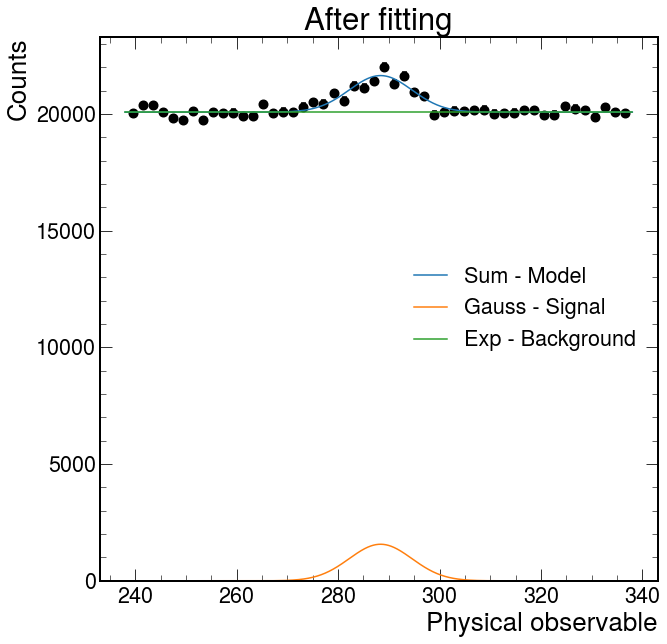

In [17]:
plt.figure()
plt.title("After fitting")
# plot the data
# plt.hist(data_np, color=color, bins=n_bins, histtype="stepfilled", alpha=0.1)
# plt.hist(data_np, color=color, bins=n_bins, histtype="step")

data_np = data[:, 0].numpy()
y = model.pdf(x).numpy()*(n_sig+n_bkg)  # rerun now after the fitting
y_gauss = (gauss.pdf(x) * n_sig).numpy()
# y_bkgr = (exponential.pdf(x) * n_bkg).numpy()
y_bkgr = (uniform.pdf(x) * n_bkg).numpy()

plt.plot(x, y*plot_scaling, label="Sum - Model")
plt.plot(x, y_gauss*plot_scaling, label="Gauss - Signal")
plt.plot(x, y_bkgr*plot_scaling, label="Exp - Background")
# plt.plot(x, y_exp*plot_scaling, label="Exp - Background")
mplhep.histplot(np.histogram(data_np, bins=n_bins), yerr=True, color='black', histtype='errorbar',
                markersize=17, capsize=2.5,
                markeredgewidth=1.5, zorder=1,
                elinewidth=1.5,
                )
plt.ylabel("Counts")
plt.xlabel("Physical observable")
plt.legend()

plt.show()